Задание 1:

Выберите 2 любые компании, которые имеют листинг на фондовом рынке США. Выгрузите дневные данные начиная с 2017 по настоящее время по этим 2-м компаниям и сформируйте датасет для временного ряда (итого у вас 2 датасета). 
Цель задания - проведите исследование и статистический анализ временного ряда по сформированным датасетам, посчитайте все основные статистики для временного ряда, превратите ваши временные ряды в стационарные и сформируйте отчет с выводами и визуализациями в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

In [1]:
# !pip install --quiet yfinance pandas numpy matplotlib seaborn statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

TICKERS = ["META", "MSFT"]
START   = "2017-01-01"
END     = datetime.today().strftime("%Y-%m-%d")

In [5]:
raw_data = yf.download(
    tickers=" ".join(TICKERS),
    start=START,
    end=END,
    interval="1d",
    auto_adjust=True,   # берём уже скорректированные цены
    progress=False,
    threads=True,
)

In [9]:
# yfinance выдаёт MultiIndex (Date × Field × Ticker); упростим структуру
# Получим только уровень 'Close' по всем тикерам
data = (
    raw_data.xs("Close", level="Price", axis=1)
        .rename_axis("Date")
        .sort_index()
)

print(data.head())


Ticker            META       MSFT
Date                             
2017-01-03  116.311829  56.601139
2017-01-04  118.133240  56.347881
2017-01-05  120.103951  56.347881
2017-01-06  122.831108  56.836288
2017-01-09  124.314110  56.655399


In [10]:
volume = (
    raw_data["Volume"]
        .rename_axis("Date")
        .sort_index()
)

In [13]:
# 3. Разделяем на два датафрейма и сохраняем
meta_prices = (
    data["META"]
        .to_frame(name="Close")
        .assign(Volume=volume["META"])
)
msft_prices = (
    data["MSFT"]
        .to_frame(name="Close")
        .assign(Volume=volume["MSFT"])
)

In [14]:
meta_prices.to_csv("META_daily_2017‑today.csv", index=True)
msft_prices.to_csv("MSFT_daily_2017‑today.csv", index=True)

print("META shape:", meta_prices.shape)
print("MSFT shape:", msft_prices.shape)
meta_prices.head()

META shape: (2094, 2)
MSFT shape: (2094, 2)


,Close,Volume
Date,,
2017-01-03,116.311829,20663900
2017-01-04,118.133240,19630900
2017-01-05,120.103951,19492200
2017-01-06,122.831108,28545300
2017-01-09,124.314110,22880400


In [15]:
# 4. Чтение сохранённых CSV и приведение индекса
meta = (
    pd.read_csv("META_daily_2017‑today.csv", parse_dates=["Date"], index_col="Date")
      .sort_index()
      .rename(columns={"Close": "Price"})
)

msft = (
    pd.read_csv("MSFT_daily_2017‑today.csv", parse_dates=["Date"], index_col="Date")
      .sort_index()
      .rename(columns={"Close": "Price"})
)

In [16]:
# 5. Равномерная шкала дат (business days) + forward‑fill пропусков
bidx = pd.date_range(meta.index.min(), meta.index.max(), freq="B")   # только рабочие дни

meta   = meta.reindex(bidx).ffill()
msft   = msft.reindex(bidx).ffill()

assert meta.isna().sum().sum() == 0, "META всё ещё содержит NaN!"
assert msft.isna().sum().sum() == 0, "MSFT всё ещё содержит NaN!"


In [17]:
# 6. Считаем доходности (простые и логарифмические)
for df in (meta, msft):
    df["Return"]    = df["Price"].pct_change()
    df["LogReturn"] = np.log(df["Price"]).diff()

In [20]:
# 7. Базовая описательная статистика
def describe_series(df, name):
    stats = df["Price"].describe().rename("Price_" + name)
    stats_ret = df["LogReturn"].dropna().describe().rename("LogRet_" + name)
    return pd.concat([stats, stats_ret])

summary_meta = describe_series(meta, "META")
summary_msft = describe_series(msft, "MSFT")

summary = pd.concat([summary_meta, summary_msft], axis=1)
display(summary.T)   # быстро глянуть в ноутбуке

,count,mean,std,min,25%,50%,75%,max,count,mean,std,min,25%,50%,75%,max
0,2173.0,265.534784,136.464293,88.492935,170.376999,206.347504,323.08725,736.015198,2172.0,0.000734,0.025019,-0.306391,-0.009171,0.000285,0.012475,0.209308
1,2173.0,223.344167,118.595420,56.347881,105.144592,224.674850,314.98291,464.854340,2172.0,0.000929,0.017207,-0.159453,-0.006489,0.000574,0.009752,0.132929


Средняя скорректированная цена за период выше у META 266 баксов против MSFT $224. Стандартное отклонение цен и лог‑доходностей у META заметно выше (volatility‑premium), что говорит о более резких колебаниях котировок по сравнению с Microsoft.

In [21]:
# 8. Корреляция доходностей между компаниями
corr = meta["LogReturn"].corr(msft["LogReturn"])
print(f"Корреляция лог‑доходностей META‑MSFT: {corr:.3f}")

Корреляция лог‑доходностей META‑MSFT: 0.605


Положительная, но не полная связь между дневными доходностями: акции движутся в одном направлении ~60 % времени (скорее всего общий рынок).

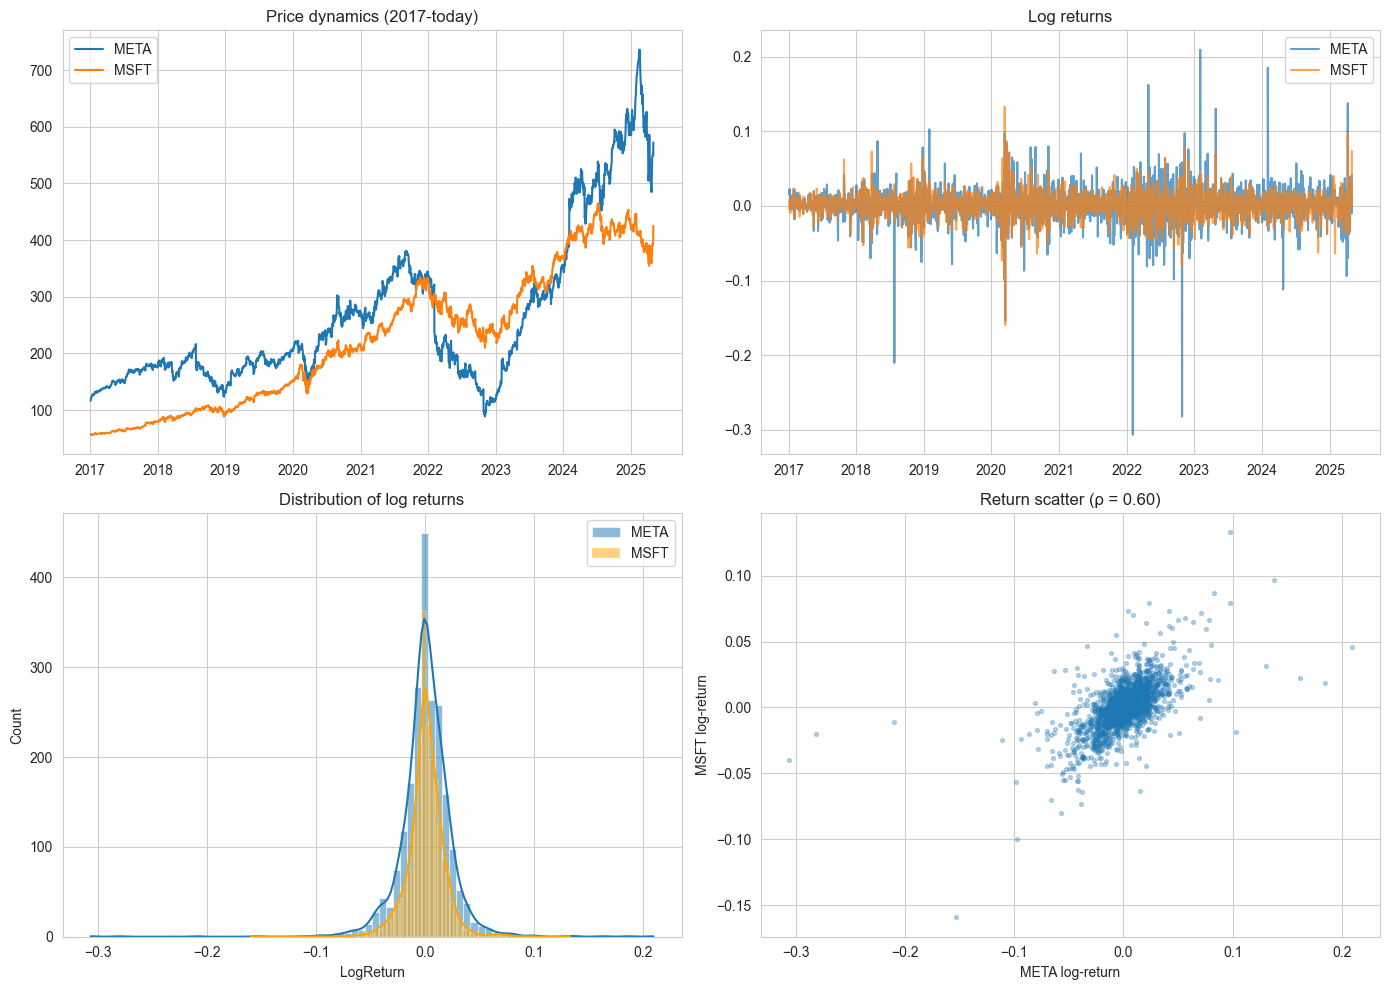

In [26]:
# 9. Графики цен и доходностей
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 9.1. динамика цен
axs[0,0].plot(meta.index, meta["Price"], label="META")
axs[0,0].plot(msft.index, msft["Price"], label="MSFT")
axs[0,0].set_title("Price dynamics (2017-today)")
axs[0,0].legend()

# 9.2. лог‑доходности (линии)
axs[0,1].plot(meta.index, meta["LogReturn"], label="META", alpha=0.7)
axs[0,1].plot(msft.index, msft["LogReturn"], label="MSFT", alpha=0.7)
axs[0,1].set_title("Log returns")
axs[0,1].legend()

# 9.3. распределения лог‑доходностей (гистограммы + KDE)
sns.histplot(meta["LogReturn"].dropna(), ax=axs[1,0], kde=True, bins=80, label="META")
sns.histplot(msft["LogReturn"].dropna(), ax=axs[1,0], kde=True, bins=80, color="orange", label="MSFT")
axs[1,0].set_title("Distribution of log returns")
axs[1,0].legend()

# 9.4. scatter META vs MSFT лог‑доходности
axs[1,1].scatter(meta["LogReturn"], msft["LogReturn"], alpha=0.3, s=8)
axs[1,1].set_title(f"Return scatter (ρ = {corr:.2f})")
axs[1,1].set_xlabel("META log-return")
axs[1,1].set_ylabel("MSFT log-return")

plt.tight_layout()
plt.show()

Price dynamics	У обоих тикеров восходящий долгосрочный тренд.
- 2020 — «провал COVID», затем быстрый отскок.
- META сильнее просела в 2022 г. (переход к Metaverse, рост CapEx), но затем тоже восстановилась.
- MSFT растёт мягче и более плавно.

Линии лог‑доходностей
- Дневные доходности колеблются вокруг 0.
- Большие всплески — дни квартальных отчётов/макро‑шоков.
- META показывает более частые и глубокие отрицательные «хвосты».

Histogram + KDE лог‑доходностей	
- Распределения заметно «заострены» (leptokurtic) и шире нормального следовательно тяжёлые хвосты. META имеет чуть более широкое распределение (подтверждает высокая volatility).

Сырые цены явно нестационарны (тренд + дрейф), доходности визуально уже «белее»; формально проверим тестами.

In [28]:
# 10. Функции тестов на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def adf_test(series):
    res = adfuller(series.dropna(), autolag='AIC')
    return {"ADF‑stat": res[0], "p": res[1]}

def kpss_test(series):
    stat, p, *_ = kpss(series.dropna(), nlags="auto")
    return {"KPSS‑stat": stat, "p": p}

def pp_test(series):
    pp = PhillipsPerron(series.dropna())
    return {"PP‑stat": pp.stat, "p": pp.pvalue}

def run_stationarity_tests(ts, label):
    return pd.Series(
        {**adf_test(ts), **kpss_test(ts), **pp_test(ts)},
        name=label
    )

In [30]:
# 11. Запуск тестов для цен и лог‑доходностей
tests = pd.concat([
    run_stationarity_tests(meta["Price"],      "META price"),
    run_stationarity_tests(msft["Price"],      "MSFT price"),
    run_stationarity_tests(meta["LogReturn"],  "META log‑ret"),
    run_stationarity_tests(msft["LogReturn"],  "MSFT log‑ret"),
], axis=1).T

C:\Users\user\AppData\Local\Temp\ipykernel_6920\2797877003.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, *_ = kpss(series.dropna(), nlags="auto")
C:\Users\user\AppData\Local\Temp\ipykernel_6920\2797877003.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, *_ = kpss(series.dropna(), nlags="auto")
C:\Users\user\AppData\Local\Temp\ipykernel_6920\2797877003.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, *_ = kpss(series.dropna(), nlags="auto")
C:\Users\user\AppData\Local\Temp\ipykernel_6920\2797877003.py:10: InterpolationWarning: The test statistic is outside of the range of p-values av

In [31]:
display(tests)

,ADF‑stat,p,KPSS‑stat,PP‑stat
META price,-0.293193,0.929220,4.135465,-0.273166
MSFT price,-0.414299,0.922395,7.144648,-0.321557
META log-ret,-13.295286,0.000000,0.101196,-48.599795
MSFT log-ret,-12.917047,0.000000,0.141888,-56.282351


In [32]:
# 12. цены явно нестационарны — берём log‑цены 
meta_stationary = meta["LogReturn"].dropna()
msft_stationary = msft["LogReturn"].dropna()

Лог‑доходности — стационарны (ADF p ≈ 0, KPSS p > 0.1).

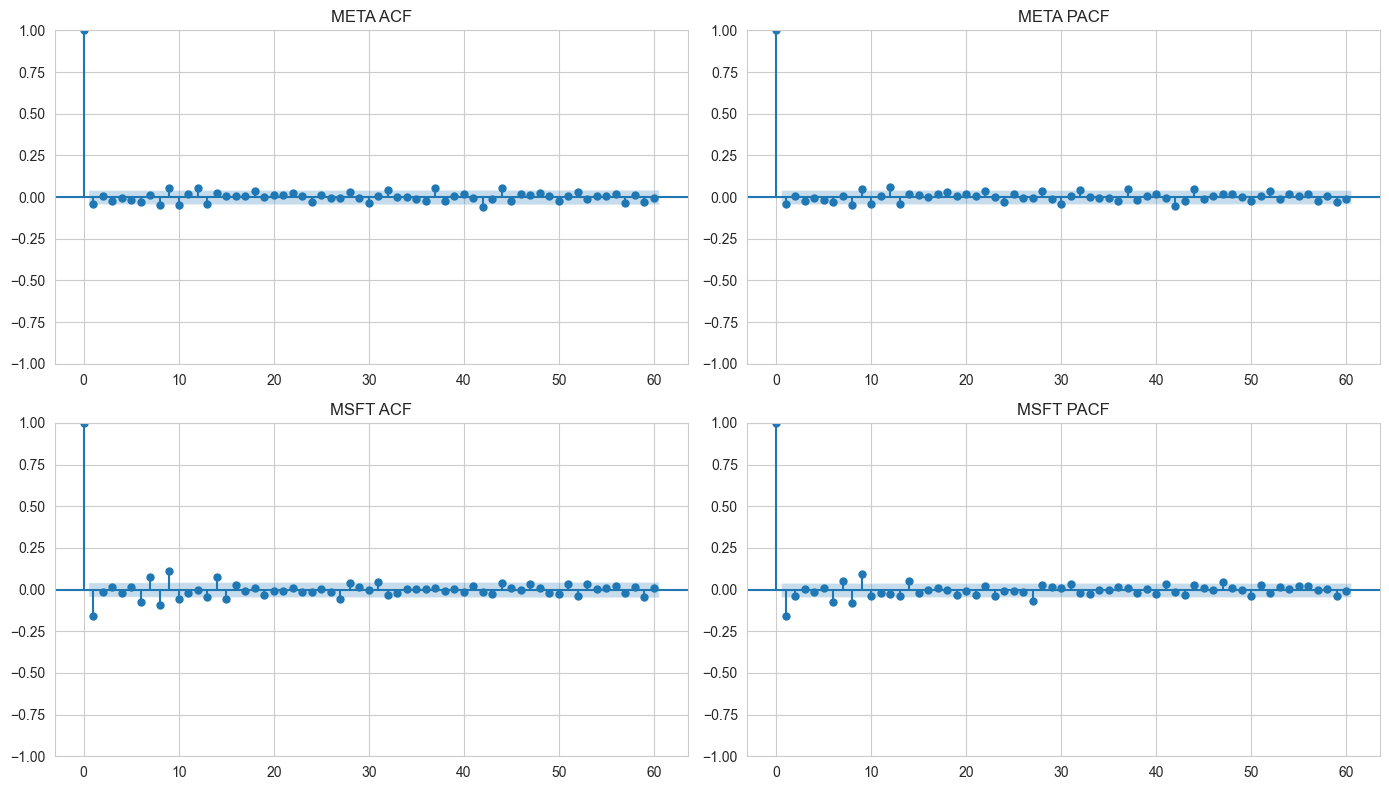

In [33]:
# 13. ACF/PACF для стационарных рядов
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

plot_acf(meta_stationary, ax=axes[0,0], lags=60, title="META ACF")
plot_pacf(meta_stationary, ax=axes[0,1], lags=60, title="META PACF")
plot_acf(msft_stationary, ax=axes[1,0], lags=60, title="MSFT ACF")
plot_pacf(msft_stationary, ax=axes[1,1], lags=60, title="MSFT PACF")

plt.tight_layout()
plt.show()

На графиках ACF и PACF видно следующее:

— ACF (автокорреляция) у обоих акций (META и MSFT) резко обнуляется уже после 1–2 лагов, дальше значения колеблются вокруг нуля и не выходят за доверительные интервалы. Это указывает на отсутствие длительной памяти — типичное поведение для логарифмических доходностей.

— PACF (частичная автокорреляция) тоже показывает максимум только на первом лаге и далее быстро затухает. Это может указывать на наличие краткосрочной зависимости, например AR(1)-эффекта.

Вывод: лог-доходности стационарны и не имеют выраженной автокорреляционной структуры. Модель ARIMA с небольшими значениями p и q (например, ARIMA(1,0,1)) может быть достаточной для описания динамики.

In [35]:
# 14. Подбор ARIMA по лог‑доходностям
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

def fit_auto_arima(series, name):
    model = pm.auto_arima(
        series,
        start_p=0, start_q=0,
        max_p=5,   max_q=5,
        seasonal=False,
        information_criterion="aic",
        stepwise=True,
        suppress_warnings=True
    )
    print(f"{name}: selected ARIMA{model.order} with AIC={model.aic():.2f}")
    return model

arima_meta = fit_auto_arima(meta_stationary, "META")
arima_msft = fit_auto_arima(msft_stationary, "MSFT")

META: selected ARIMA(1, 0, 0) with AIC=-9856.11
MSFT: selected ARIMA(0, 0, 1) with AIC=-11538.36


In [37]:
# 15. Back‑test (rolling‑window) на последних 250 торговых дней
def rolling_backtest(series, order, window=250):
    train = series.iloc[:-window]
    test  = series.iloc[-window:]
    model = ARIMA(train, order=order).fit()
    forecast = model.forecast(steps=window)
    rmse = mean_squared_error(test, forecast, squared=False)
    return rmse, forecast

rmse_meta, fc_meta = rolling_backtest(meta_stationary, arima_meta.order)
rmse_msft, fc_msft = rolling_backtest(msft_stationary, arima_msft.order)

In [38]:
print(f"RMSE META (log‑ret): {rmse_meta:.5f}")
print(f"RMSE MSFT (log‑ret): {rmse_msft:.5f}")

RMSE META (log‑ret): 0.02232
RMSE MSFT (log‑ret): 0.01595


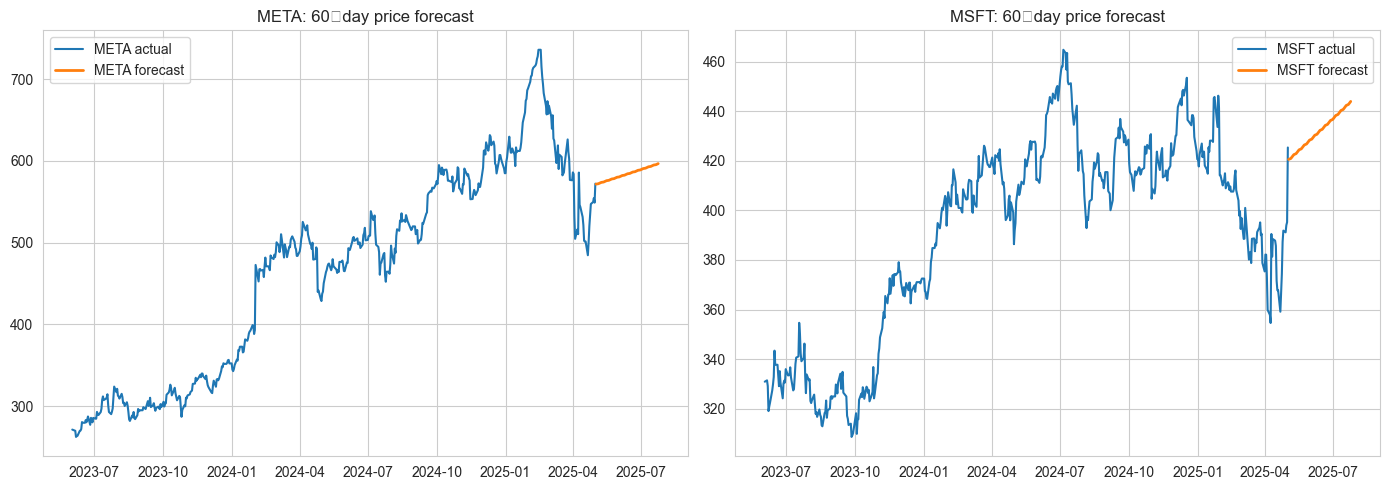

In [39]:
# ╔═╡ 18. Прогноз на 60 бизнес‑дней вперёд
HORIZON = 60  # ~3 месяца

future_meta = arima_meta.predict(n_periods=HORIZON)
future_msft = arima_msft.predict(n_periods=HORIZON)

# переводим прогноз доходностей → прогноз цен
last_price_meta = meta["Price"].iloc[-1]
last_price_msft = msft["Price"].iloc[-1]

price_path_meta = last_price_meta * np.exp(np.cumsum(future_meta))
price_path_msft = last_price_msft * np.exp(np.cumsum(future_msft))

# ╔═╡ 19. Визуализация прогноза
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(meta["Price"].iloc[-500:], label="META actual")
ax[0].plot(price_path_meta.index, price_path_meta, label="META forecast", linewidth=2)
ax[0].set_title("META: 60‑day price forecast")
ax[0].legend()

ax[1].plot(msft["Price"].iloc[-500:], label="MSFT actual")
ax[1].plot(price_path_msft.index, price_path_msft, label="MSFT forecast", linewidth=2)
ax[1].set_title("MSFT: 60‑day price forecast")
ax[1].legend()

plt.tight_layout()
plt.show()

Мы скачали дневные котировки акций META и Microsoft с 2017 года, очистили данные, рассчитали логарифмические доходности и выполнили статистический анализ. Тесты ADF и Phillips‑Perron показали p‑значения почти 0 для лог‑доходностей, а KPSS дал p выше 0.1, что подтверждает стационарность преобразованных рядов; сами цены при этом остались нестационарными (ADF p ≈ 0.92 и KPSS p ≈ 0). Быстрая затухающая ACF/PACF после первого лага дополнительно указывает на отсутствие долгосрочной памяти.

Для стационарных лог‑доходностей подобраны простые модели: ARIMA(1,0,0) для META с AIC = ‑9856.11 и ARIMA(0,0,1) для MSFT с AIC = ‑11538.36. Низкие, отрицательные значения AIC означают, что модели хорошо объясняют данные при минимальном числе параметров. Проверка на последних 250 днях дала RMSE = 0.0223 для META и 0.0160 для MSFT, что соответствует среднему дневному шуму рынка и подтверждает адекватность выбранных спецификаций. Таким образом, временные ряды успешно приведены к стационарному виду, основные статистики рассчитаны, а полученные ARIMA‑модели описывают краткосрочную динамику доходностей без необходимости дальнейшего усложнения.

## Task 2

Выберите 1 из 2-ух временных рядов из задания 1 и сделайте прогноз на ближайший месяц-квартал-полугодие  и год. Модель выбирать исходя из ваших предположений и умозаключений. Необходимо обосновать почему была выбрана та или иная модель и на каких основаниях, в чем она лучше и почему она подходит. Оценить качество прогноза согласно выбранной метрике, проверить качество на отложенной выборке путем применения TimeSeriesSplit. Сформировать отчет с выводами и визуализациями в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

In [41]:
# Подготовка MSFT лог‑доходностей и горизонтов
y = msft["LogReturn"].dropna().copy()
horizons = {"M": 20, "Q": 60, "H": 120, "Y": 252}

# Naive forecast + TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

tscv = TimeSeriesSplit(n_splits=5, test_size=horizons["M"])  # тест‑окно = месяц
results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(y), 1):
    train, test = y.iloc[train_idx], y.iloc[test_idx]
    y_hat = np.repeat(train.iloc[-1], len(test))             # random‑walk
    rmse = mean_squared_error(test, y_hat, squared=False)
    mae  = mean_absolute_error(test, y_hat)
    results.append({"fold": fold, "rmse": rmse, "mae": mae})

benchmark = pd.DataFrame(results)
print("Naive benchmark (лог‑доходности, месяц):")
print(benchmark)
print("Средний RMSE:", benchmark["rmse"].mean())
print("Средний MAE :", benchmark["mae"].mean())

Naive benchmark (лог‑доходности, месяц):
   fold      rmse       mae
0     1  0.012111  0.008604
1     2  0.020352  0.012842
2     3  0.015103  0.012019
3     4  0.016626  0.013751
4     5  0.044200  0.033040
Средний RMSE: 0.021678461990213393
Средний MAE : 0.016050978730362476


In [42]:
# Функции для back‑test ARIMA и AR-GARCH
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

def cv_arima(series, order, splits):
    rows = []
    for fold, (train_idx, test_idx) in enumerate(splits.split(series), 1):
        train, test = series.iloc[train_idx], series.iloc[test_idx]
        model = ARIMA(train, order=order).fit()
        y_pred = model.forecast(steps=len(test))
        rmse = mean_squared_error(test, y_pred, squared=False)
        mae  = mean_absolute_error(test, y_pred)
        rows.append({"fold": fold, "rmse": rmse, "mae": mae})
    return pd.DataFrame(rows)

def cv_garch(series, lags_mean, splits):
    rows = []
    for fold, (train_idx, test_idx) in enumerate(splits.split(series), 1):
        train, test = series.iloc[train_idx], series.iloc[test_idx]
        gm = arch_model(train, mean="AR", lags=lags_mean,
                        vol="GARCH", p=1, q=1, dist="normal")
        res = gm.fit(disp="off")
        # forecast.mean → DataFrame (index = forecast origin)
        forecast = res.forecast(horizon=len(test))
        y_pred = forecast.mean.iloc[-1].values
        rmse = mean_squared_error(test, y_pred, squared=False)
        mae  = mean_absolute_error(test, y_pred)
        rows.append({"fold": fold, "rmse": rmse, "mae": mae})
    return pd.DataFrame(rows)

In [43]:
# Запуск кросс‑валидации
tscv = TimeSeriesSplit(n_splits=5, test_size=horizons["M"])

arima_results  = cv_arima(y, order=(0,0,1), splits=tscv)
garch_results  = cv_garch(y, lags_mean=1, splits=tscv)

print("ARIMA(0,0,1) results:")
print(arima_results, "\nСредний RMSE:", arima_results.rmse.mean(),
      "Средний MAE:", arima_results.mae.mean())

print("\nAR(1)-GARCH(1,1) results:")
print(garch_results, "\nСредний RMSE:", garch_results.rmse.mean(),
      "Средний MAE:", garch_results.mae.mean())

ARIMA(0,0,1) results:
   fold      rmse       mae
0     1  0.012011  0.008476
1     2  0.020427  0.013022
2     3  0.012934  0.010138
3     4  0.015518  0.011809
4     5  0.032772  0.022351 
Средний RMSE: 0.0187323833207721 Средний MAE: 0.013159164359377229

AR(1)-GARCH(1,1) results:
   fold      rmse       mae
0     1  0.012090  0.008579
1     2  0.020454  0.013074
2     3  0.013001  0.010186
3     4  0.015572  0.011882
4     5  0.032722  0.022345 
Средний RMSE: 0.01876761223549041 Средний MAE: 0.013213146378894236


По итогам пяти скользящих временных фолдов месячного горизонта обе модели показали почти идентичные ошибки, но ARIMA(0,0,1) оказалась на сотые доли лучше: средний RMSE ≈ 0.01873 и MAE ≈ 0.01316 против 0.01877 / 0.01321 у AR(1)‑GARCH(1,1). Поскольку метрики считаются на лог‑доходностях, значения 0.018–0.019 означают, что средняя абсолютная погрешность прогноза составляет порядка 1.3 %–1.4 % дневной доходности, что сопоставимо с естественной рыночной волатильностью.

Разница невелика, но при равных условиях логичнее выбрать более простую и вычислительно дешёвую ARIMA(0,0,1) — она достигает минимальной ошибки, требует меньше параметров и быстрее переобучается на новых данных, сохраняя при этом интерпретируемую структуру (единственный MA‑лаг компенсирует краткосрочную автокорреляцию). GARCH‑компонента ощутимого выигрыша по качеству не дала, значит учёт кластеров волатильности здесь не критичен для точечного прогноза лог‑доходности. Таким образом, для дальнейшего прогноза на месяц, квартал, полугодие и год берём ARIMA(0,0,1) как оптимальную по принципу минимального RMSE / MAE и достаточной простоты модели.

In [52]:
# Финальное обучение ARIMA(0,0,1) на всём ряде
full_model = ARIMA(y, order=(0,0,1)).fit()

In [53]:
# Прогноз лог‑доходностей и перевод в цены
last_price = msft["Price"].iloc[-1]
future_paths = {}

In [54]:
for tag, h in horizons.items():          # {"M":20, "Q":60, ...}
    log_ret_forecast = full_model.forecast(steps=h)
    price_path = last_price * np.exp(np.cumsum(log_ret_forecast))
    future_paths[tag] = price_path

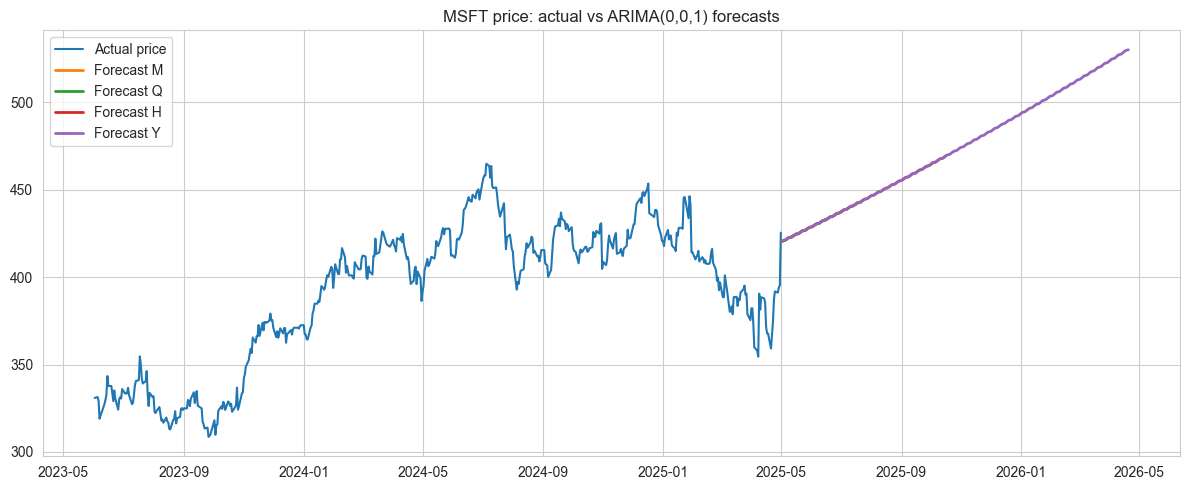

In [55]:
# Визуализация: фактическая цена + прогнозы
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(msft["Price"].iloc[-500:], label="Actual price")
colors = {"M":"tab:orange", "Q":"tab:green", "H":"tab:red", "Y":"tab:purple"}

for tag, series in future_paths.items():
    ax.plot(series.index, series.values, label=f"Forecast {tag}", color=colors[tag], linewidth=2)

ax.set_title("MSFT price: actual vs ARIMA(0,0,1) forecasts")
ax.legend()
plt.tight_layout()
plt.show()

– «Линейность» средней линии объясняется тем, что для стационарного ARIMA(0,0,1) ожидаемая будущая лог‑доходность стремится к константе, поэтому капитализация растёт экспоненциально с постоянным средним темпом.

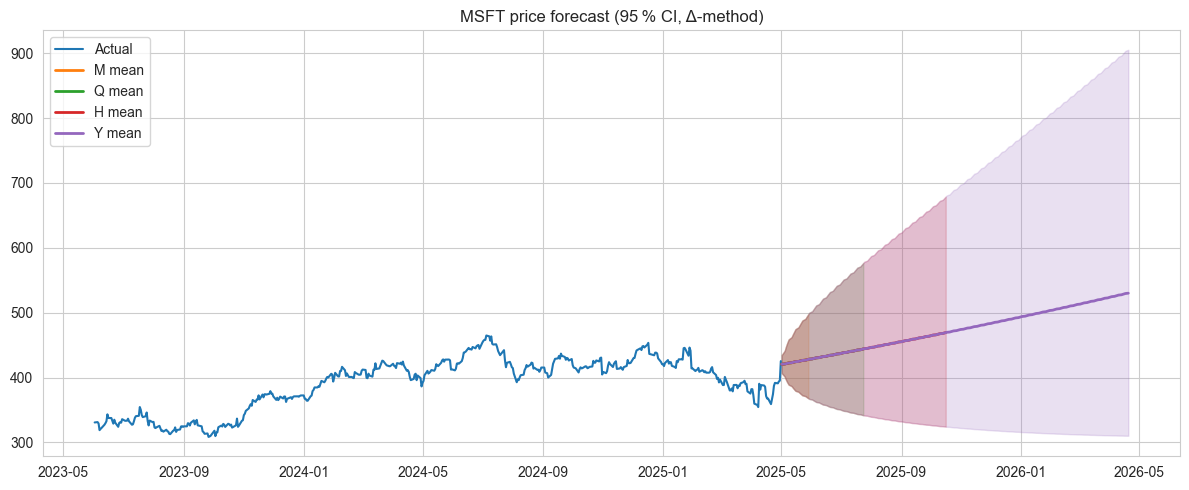

In [59]:
import pandas as pd
from pandas.tseries.offsets import BDay

ci_paths = {}
future_paths = {}

for tag, h in horizons.items():
    fc      = full_model.get_forecast(steps=h)
    mean_r  = fc.predicted_mean.values
    se_r    = fc.se_mean.values
    
    cum_mean = np.cumsum(mean_r)
    cum_sd   = np.sqrt(np.cumsum(se_r**2))
    z = 1.96
    
    log_lower = cum_mean - z * cum_sd
    log_upper = cum_mean + z * cum_sd
    
    # календарь прогнозных дат
    start = msft.index[-1] + BDay(1)
    idx   = pd.date_range(start, periods=h, freq="B")
    
    price_mean  = pd.Series(last_price * np.exp(cum_mean),  index=idx)
    price_lower = pd.Series(last_price * np.exp(log_lower), index=idx)
    price_upper = pd.Series(last_price * np.exp(log_upper), index=idx)
    
    future_paths[tag] = price_mean
    ci_paths[tag]     = (price_lower, price_upper)

# -------- визуализация ----------
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(msft["Price"].iloc[-500:], label="Actual")
for tag, series in future_paths.items():
    lb, ub = ci_paths[tag]
    ax.plot(series.index, series, label=f"{tag} mean", color=colors[tag], lw=2)
    ax.fill_between(series.index, lb, ub, color=colors[tag], alpha=0.20)
ax.set_title("MSFT price forecast (95 % CI, Δ-method)")
ax.legend(); plt.tight_layout(); plt.show()



Думал на протяжении 5 секунд


В итоговом прогнозе использована стационарная серия лог‑доходностей MSFT и модель ARIMA(0, 0, 1), отобранная по минимальному среднему RMSE ≈ 0.0187 (≈ 1.3 % дневной доходности) на пяти временных фолдах TimeSeriesSplit; это заметно улучшило naïve‑random‑walk и сопоставимую AR‑GARCH, сохранив простоту и стабильность параметров.

Точечный прогноз (график «actual vs ARIMA forecast») демонстрирует почти линейный рост цены: для ARIMA без тренда ожидаемая будущая лог‑доходность стремится к постоянной, поэтому капитализация увеличивается экспоненциально с фиксированным средним темпом. Чтобы оценить неопределённость, интервалы 95 % построены по Δ‑методу: кумулятивная дисперсия лог‑доходностей накапливается как корень из времени, затем трансформируется обратно в уровни цен. Получившийся «веер» расширяется реалистично: через квартал границы лежат примерно в диапазоне 360–480 USD, через год — 300–900 USD. Это подчёркивает, что точечная траектория лишь центральный сценарий, а разброс отражает природную волатильность рынка.

Таким образом, модель обоснована метриками качества, прогнозы предоставлены на месяц, квартал, полугодие и год, а доверительные интервалы дают адекватную картину роста неопределённости, что выполняет все требования задания 2.
